## Combinatorial Optimization Workshop using the Qmod quantum types - part 1

In this workshop, we will solve the MaxCut problem using qmod's quantum types, such as `QBit`, and the phase function. First, we will have introduction to the Maximum Cut (MaxCut) problem.

#### Guidance for the workshop:
**The `# TODO` is there for you to do yourself.**
**The `# Solution start` and `# Solution end` are only for helping you. Please delete the `Solution` and try doing it yourself...**

### Introduction

The "Maximum Cut Problem" (MaxCut) [[1](#MaxCutWiki)] is an example of combinatorial optimization problem. It refers to finding a partition of a graph into two sets, such that the number of edges between the two sets is maximal. This optimization problem is the cardinal example in the context of Quantum Approximate Optimization Algorithm [[2](#QAOA)], since it is an unconstrained problem whose objective function in terms quantum gates can be derived easily. With the Classiq platform, things are even simpler, as the objective function is inserted in its arithmetic form.

### Mathematical formulation

Given a graph $G=(V,E)$ with $|V|=n$ nodes and $E$ edges, a cut is defined as a partition of the graph into two complementary subsets of nodes. In the MaxCut problem we are looking for a cut where the number of edges between the two subsets is maximal. We can represent a cut of the graph by a binary vector $x$ of size $n$, where we assign 0 and 1 to nodes in the first and second subsets, respectively. The number of connecting edges for a given cut is simply given by summing over $x_i (1-x_j)+x_j (1-x_i)$ for every pair of connected nodes $(i,j)$.

### Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. 

In [19]:
import math

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.optimize import minimize

from classiq import *

#### Creating and plotting the graph, the MaxCut problem

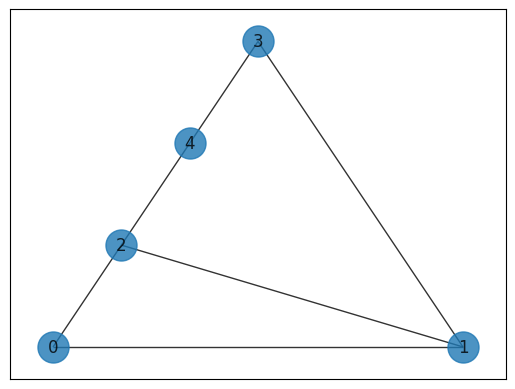

In [20]:
graph_nodes = [0, 1, 2, 3, 4]
graph_edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]

G = nx.Graph()
G.add_nodes_from(graph_nodes)
G.add_edges_from(graph_edges)
pos = nx.planar_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, alpha=0.8, node_size=500)

## Create the classical optimization function

First, build a function that whether to count an edge or not. If the two nodes are from different groups, the function `edge_cut` will return 1, otherwise, it should return 0. The values of the nodes are binary.

In [21]:
def edge_cut(node1_group_bit, node2_group_bit):
    # TODO: This function should return 1 if the two nodes are in different groups, and 0 if they're in the same group.
    # The n_bit is a bit that specifies 0 or 1 - depending on which group the node is in.

    # Your code

    # Solution start
    return node1_group_bit * (1 - node2_group_bit) + node2_group_bit * (
        1 - node1_group_bit
    )
    # Solution end

Implement a function that returns the total cost for a cut on the graph.

In [22]:
def maxcut_cost(v: QArray[QBit]):
    # TODO: Your code should loop through the graph edges and
    # sum over the edge cut using the edge_cut function.
    # You should return the negative cost.
    # Because at the optimization, we will use a minimization in the optimization process.

    # Your code

    # Solution start
    return -sum(edge_cut(v[node1], v[node2]) for (node1, node2) in G.edges)
    # Solution end

#### Generic building blocks for QAOA circuit

The mixer layer will apply `RX` gates with parameter beta to all qubits in the `qba` array.

In [23]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    # TODO: Apply on all qubits the RX gate with the beta rotation angle.
    # You can use apply_to_all or with repeat

    # Your code

    # Solution start
    apply_to_all(lambda q: RX(beta, q), qba)
    # Solution end

#### The phase function

In the QAOA ansatz, the cost layer gives a phase to any solution type. Therefore, we will use the `phase` function which takes an expression (`phase_expr`) and a parameter (`theta`) as arguments. See more [here](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/phase/).

For example:
```
phase(
    phase_expr=maxcut_cost(v),
    theta=gamma
)
```

The `phase` function rotates each computational basis state about the Z axis with the angle $\theta$ relative the value of the expression `phase_expr`. Namely, it adds a phase to each quantum state $|x\rangle \rightarrow e^{f(x_1,x_2,...,x_n)}|x\rangle$ with respect to the value that $f(x_1,x_2,...,x_n)$ returns. The quantum variables $x_1,x_2,...,x_n$ constitute the quantum state $|x\rangle$.

#### Problem specifc building blocks

In [24]:
# Define the number of layers you want. It is a heuristic decision, as the number of layers increases, the solution quality increases.


NUM_LAYERS = 4

# In the main function you will create the ansatz.

# The qaoa ansatz have 2 parts:
# 1. Apply a H gate to all qubits in the `v` register
# 2. Create N number of layers.
# Each layer will apply a cost layer using the `phase` function,
# this will take gammas as argument
# and `mixer_layer()` this will take betas as argument.


@qfunc
def main(
    params: CArray[CReal, NUM_LAYERS * 2],
    v: Output[QArray[QBit]],
):
    # TODO:
    # Allocate the number of qubits in the circuit.
    # What should be the number of qubits?

    # Apply the initial initialization of QAOA

    # Apply repeatedly the alternating sequence of operators:
    # 1. The cost layer with the gamma parameter using the `phase` function.
    # 2. The mixer layer with the beta parameter.
    # Note that for the optimizer, it doesn't matter which parameter is gamma and which beta

    # Your code

    # Solution start
    allocate(len(G.nodes), v)
    hadamard_transform(v)

    repeat(
        count=params.len / 2,
        iteration=lambda i: (
            phase(maxcut_cost(v), params[2 * i]),
            mixer_layer(params[2 * i + 1], v),
        ),
    )
    # Solution end

#### Synthesizing and visualizing 

In [25]:
qprog = synthesize(main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2ygfaHFi4lcAFyuwYn3X64Vr6wC


## Execution and post processing

For the hybrid execution, we use `ExecutionSession`, which can evaluate the circuit in multiple methods, such as sampling the circuit, giving specific values for the parameters, and evaluating to a specific Hamiltonian, which is very common in chemical applications.

In QAOA, we will use the `estimate_cost` method, which samples the cost function and returns their average cost from all measurements. That helps to optimize easily.

In [26]:
NUM_SHOTS = 1000
# The number of shots is also a heuristic decision. The more shots, the more probability to get the right solution, especially when the number of qubits is large.

ES = ExecutionSession(
    qprog, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

A good initialization of QAOA is linearly approach the $\gamma$ values from 0 to 1 and the $\beta$ values from 1 to 0. This approach showed better solutions because it is similar to the adiabatic evolution with big steps rather than small evolution. Some suggest the value 0.75 bring better solutions.

In [27]:
# TODO:
# Build `initial_params` list of np.array type.
# The gamma values should start from 0 and, in each layer, should approach closer to 1 linearly
# The beta values should start from 1 and in each layer, should approach closer to 0 linearly
# Then unify it to one list so scipy minimize can digest it.

# Your code


# Solution start
def initial_qaoa_params(NUM_LAYERS) -> np.ndarray:
    initial_gammas = np.linspace(0, 1, NUM_LAYERS)
    initial_betas = np.linspace(1, 0, NUM_LAYERS)

    initial_params = []

    for i in range(NUM_LAYERS):
        initial_params.append(initial_gammas[i])
        initial_params.append(initial_betas[i])

    return np.array(initial_params)


# Solution end


initial_params = initial_qaoa_params(NUM_LAYERS)

Record the steps of the optimization.

In [28]:
intermediate_params = []
objective_values = []

Build the classical cost function that take a single state and return its cut.

In [29]:
cost_func = lambda state: maxcut_cost(state["v"])

Use the `ExecutionSession` to calculate the cost of all measurements at once using the `estimate_cost` method.

In [30]:
def estimate_cost_func(params) -> float:
    obj_value = ES.estimate_cost(
        cost_func=cost_func, parameters={"params": params.tolist()}
    )
    objective_values.append(obj_value)
    return obj_value

In the QAOA algorithm, the classical cost function is converted to a Hamiltonian and the `estimate_cost` method give the $
⟨H_C{\displaystyle \rangle }$. But you can define anything with the `estimate_cost`, not necessarily the expectation value of the Hamiltonian.

Define the callback function to store the intermediate parameters or any intermediate parameter you wish.

In [31]:
def callback(xk):
    intermediate_params.append(xk)

Now, make the optimization part using the `minimize` function from `scipy`. You need to combine the objective function, which includes the quantum program, the classical optimizer, and the `callback` function.

To achieve better convergence, you need to define the type of optimizer (such as `COBYLA`), the number of iterations, and other parameters, depending on the type of optimizer.

In [32]:
optimization_res = minimize(
    estimate_cost_func,
    x0=initial_params,
    method="COBYLA",
    callback=callback,
    options={"maxiter": 40},
)

The `maxiter` is the number of iterations. As the number of layers is larger, we need more iterations to converge to a good solution because there are more parameters.

After we finish the optimization and find good parameters, we will use them once again to find the optimized solution.

In [33]:
res = ES.sample({"params": optimization_res.x.tolist()})

In [34]:
print(f"Optimized parameters: {optimization_res.x.tolist()}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: maxcut_cost(pc.state["v"]))
for sampled in sorted_counts:
    v = sampled.state["v"]
    print(
        f"solution={sampled.state['v']} probability={sampled.shots/NUM_SHOTS} cost={maxcut_cost(sampled.state['v'])}"
    )

Optimized parameters: [0.385868970608936, 0.8721911218564776, 0.5847145604691053, 0.6640882010419554, 0.9694404571883897, 0.5148214977396823, 2.15158726630142, -0.11433716659702076]
solution=[0, 1, 0, 0, 1] probability=0.218 cost=-5
solution=[1, 0, 1, 1, 0] probability=0.207 cost=-5
solution=[0, 0, 1, 1, 0] probability=0.183 cost=-5
solution=[1, 1, 0, 0, 1] probability=0.178 cost=-5
solution=[0, 1, 1, 0, 0] probability=0.044 cost=-4
solution=[1, 0, 0, 1, 1] probability=0.041 cost=-4
solution=[0, 1, 1, 1, 0] probability=0.033 cost=-4
solution=[1, 0, 0, 0, 1] probability=0.022 cost=-4
solution=[1, 0, 0, 1, 0] probability=0.022 cost=-4
solution=[0, 1, 1, 0, 1] probability=0.022 cost=-4
solution=[1, 0, 1, 0, 0] probability=0.002 cost=-3
solution=[1, 1, 0, 0, 0] probability=0.002 cost=-3
solution=[0, 0, 1, 0, 1] probability=0.001 cost=-3
solution=[1, 1, 0, 1, 0] probability=0.001 cost=-3
solution=[0, 1, 0, 1, 0] probability=0.001 cost=-3
solution=[1, 0, 1, 0, 1] probability=0.001 cost=-3
so

### Plot the result

Let's plot the result of the best found solution.

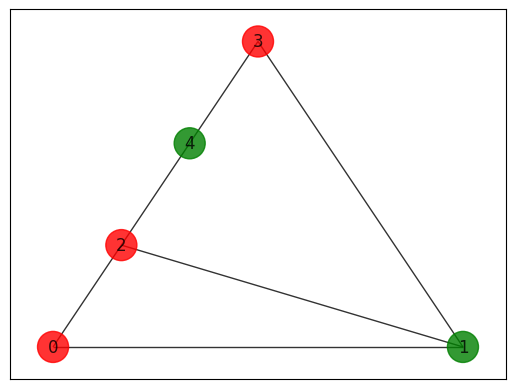

In [35]:
colors = [
    "r" if sorted_counts[0].state["v"][i] == 0 else "g"
    for i in range(len(sorted_counts[0].state["v"]))
]

nx.draw_networkx(
    G, pos=pos, with_labels=True, alpha=0.8, node_size=500, node_color=colors
)

## Plot the convergence graph

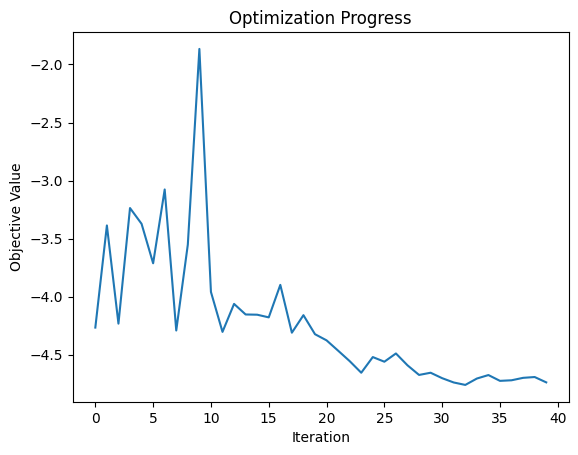

In [36]:
# TODO:
# Show the optimization progress to see if you converged to a good solution

# You code

# Solution start
plt.plot(objective_values)
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Optimization Progress")
plt.show()
# Solution end

# Changes to play with
1. Change the type of the optimizer from the scipy [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.
2. Each optimizer has another type step size. For example, in the COBYLA optimizer, it is called `rhobeg`. The step size determines how far the optimizer will go in each iteration. You can change it to see how it affects the convergence.
3. Do the same optimization process for a random [Erdos Renyi graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html).
4. Build a weighted graph in which each edge has a different weight, and solve the maxcut with it. This type of graphs are more realistic for real-life applications and also NP-hard.

## References

<a id='MaxCutWiki'>[1]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
